## 轉換資料格式

In [5]:
import pandas as pd
import os

def convert_IMDB_to_csv(directory, csv_file_path):
    data = []
    labels = []
    for label in ['pos', 'neg']: # 讀取標籤資料
        for subset in ['train', 'test']: # 讀取訓練和測試資料
            path = f"{directory}/{subset}/{label}"
            for file in os.listdir(path):
                if file.endswith(".txt"): # 判斷結尾是.txt才能讀取資料
                    with open(f'{path}/{file}', 'r', encoding='utf-8') as f:
                        data.append(f.read()) # 加入文本資料
                        labels.append('positive' if label == 'pos' else 'negative') # 根據資料夾名稱轉換標籤
    df = pd.DataFrame({'review': data, 'sentiment': labels})
    df.to_csv(csv_file_path, index=False) # 加入 index=False 避免 DataFrame 產生預設的索引欄位

convert_IMDB_to_csv('aclImdb', 'imdb_data.csv')

## 固定亂數

In [6]:
import torch
import numpy as np
import random

def set_seeds(seed):
    random.seed(seed)  # 設定 Python 標準庫的亂數生成器種子
    np.random.seed(seed)  # 設定 NumPy 亂數生成器種子
    torch.manual_seed(seed)  # 設定 PyTorch 的 CPU 亂數生成器種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設定 PyTorch 在單個 GPU 上的亂數種子
        torch.cuda.manual_seed_all(seed)  # 設定 PyTorch 在所有 GPU 上的亂數種子
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基準測試功能
    torch.backends.cudnn.deterministic = True  # 強制 cuDNN 使用確定性算法

set_seeds(2526)

## 重新加載檔案

In [7]:
import pandas as pd

 # 讀取CSV資料
df = pd.read_csv('imdb_data.csv')

# 讀取文章與情緒欄位
reviews = df['review'].values
sentiments = df['sentiment'].values

# 將情緒資料轉換成數字資料
labels = (sentiments == 'positive').astype('float32')
print(labels)

[1. 1. 1. ... 0. 0. 0.]


## 讀英文Tokenizer

In [8]:
# 讀取別人使用BPE斷詞所建立的Tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
input_datas = tokenizer(reviews[:2].tolist(), max_length=10, truncation=True, padding="longest", return_tensors='pt')

# 觀看結果
print('Tokenizer輸出:')
print(input_datas)
print('還原文字:')
print(tokenizer.decode(input_datas['input_ids'][0]))
print(tokenizer.decode(input_datas['input_ids'][1]))

Tokenizer輸出:
{'input_ids': tensor([[  101, 22953,  2213,  4381,  2152,  2003,  1037,  9476,  4038,   102],
        [  101, 11573,  2791,  1006,  2030,  2160, 24913,  2004,  2577,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
還原文字:
[CLS] bromwell high is a cartoon comedy [SEP]
[CLS] homelessness ( or houselessness as george [SEP]


## 轉換成DataLoader

In [9]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class IMDB(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):    
        batch_x, batch_y = zip(*batch)
        input_ids = self.tokenizer(batch_x, max_length=128, truncation=True, padding="longest", return_tensors='pt').input_ids[:,1:-1] # 移除[CLS]與[SEP]標籤
        labels = torch.tensor(batch_y)
        return {'input_ids': input_ids, 'labels': labels}

# 分割資料集
x_train, x_valid, y_train, y_valid = train_test_split(reviews, labels, train_size=0.8, random_state=46, shuffle=True)

# 建立Dataset
trainset = IMDB(x_train, y_train, tokenizer)
validset = IMDB(x_valid, y_valid, tokenizer)

# DataLoader
valid_loader = DataLoader(validset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=validset.collate_fn)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, collate_fn=trainset.collate_fn)


## 建立時間序列模型

In [10]:
import torch.nn as nn
import torch.optim as optim 

class TimeSeriesModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, padding_idx, num_layers=1, bidirectional=True, model_type='LSTM'):
        super().__init__()
        self.criterion = nn.BCELoss() #定義損失函數
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx) 
        
        # 切換模型
        rnn_models = {'LSTM': nn.LSTM, 'GRU': nn.GRU, 'RNN': nn.RNN}
        self.series_model = rnn_models.get(model_type, nn.LSTM) (
            embedding_dim, 
            hidden_size,
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            batch_first=True
        )

        # 如果是雙向運算則最終的hidden state會變成2倍
        hidden = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, **kwargs):
        # 取得輸入資料
        input_ids = kwargs['input_ids']
        labels = kwargs['labels']          
        #轉換成詞嵌入向量
        emb_out = self.embedding(input_ids)
        # 時間序列模型進行運算
        output, h_n = self.series_model(emb_out)
        # output: (batch_size, seq_len, hidden_size * 2)
        h_t = output[:, -1, :]
        # h_t: (batch_size, 1, hidden_size * 2)
        y_hat = self.sigmoid(self.fc(h_t))
        # h_t: (batch_size, 1)

        # 返回loss與logit
        return self.criterion(y_hat.view(-1), labels), y_hat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 創建模型並將其移動到適當的設備上
model = TimeSeriesModel(
    vocab_size=len(tokenizer), 
    embedding_dim=50, 
    hidden_size=32, 
    model_type='LSTM', 
    padding_idx=tokenizer.pad_token_id
).to(device)
# 定義優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 使用訓練器訓練模型

Valid Epoch 0: 100%|██████████| 313/313 [00:03<00:00, 101.96it/s, loss=0.648]


Saving Model With Loss 0.68101
Train Loss: 0.68988| Valid Loss: 0.68101| Best Loss: 0.68101



Valid Epoch 1: 100%|██████████| 313/313 [00:03<00:00, 94.98it/s, loss=0.583]


Saving Model With Loss 0.62546
Train Loss: 0.64642| Valid Loss: 0.62546| Best Loss: 0.62546



Valid Epoch 2: 100%|██████████| 313/313 [00:03<00:00, 95.13it/s, loss=0.612]


Saving Model With Loss 0.55239
Train Loss: 0.56124| Valid Loss: 0.55239| Best Loss: 0.55239



Valid Epoch 3: 100%|██████████| 313/313 [00:03<00:00, 95.48it/s, loss=0.703]


Train Loss: 0.48983| Valid Loss: 0.63323| Best Loss: 0.55239



Valid Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 95.01it/s, loss=0.332]


Saving Model With Loss 0.51167
Train Loss: 0.47185| Valid Loss: 0.51167| Best Loss: 0.51167



Valid Epoch 5: 100%|██████████| 313/313 [00:03<00:00, 95.02it/s, loss=0.392]


Saving Model With Loss 0.46919
Train Loss: 0.40292| Valid Loss: 0.46919| Best Loss: 0.46919



Valid Epoch 6: 100%|██████████| 313/313 [00:03<00:00, 94.82it/s, loss=0.323] 


Saving Model With Loss 0.46857
Train Loss: 0.34803| Valid Loss: 0.46857| Best Loss: 0.46857



Valid Epoch 7: 100%|██████████| 313/313 [00:03<00:00, 95.47it/s, loss=0.777]


Saving Model With Loss 0.45769
Train Loss: 0.30643| Valid Loss: 0.45769| Best Loss: 0.45769



Valid Epoch 8: 100%|██████████| 313/313 [00:03<00:00, 95.30it/s, loss=0.567]


Train Loss: 0.28875| Valid Loss: 0.50595| Best Loss: 0.45769



Valid Epoch 9: 100%|██████████| 313/313 [00:03<00:00, 95.21it/s, loss=0.796]


Train Loss: 0.24769| Valid Loss: 0.47706| Best Loss: 0.45769



Valid Epoch 10: 100%|██████████| 313/313 [00:03<00:00, 95.89it/s, loss=0.409]


Train Loss: 0.23028| Valid Loss: 0.54238| Best Loss: 0.45769



Valid Epoch 11: 100%|██████████| 313/313 [00:03<00:00, 95.81it/s, loss=0.407]


Train Loss: 0.19422| Valid Loss: 0.51193| Best Loss: 0.45769



Valid Epoch 12: 100%|██████████| 313/313 [00:03<00:00, 91.70it/s, loss=0.606]


Train Loss: 0.17103| Valid Loss: 0.55685| Best Loss: 0.45769



Valid Epoch 13: 100%|██████████| 313/313 [00:03<00:00, 95.89it/s, loss=0.494]


Train Loss: 0.15553| Valid Loss: 0.53548| Best Loss: 0.45769



Valid Epoch 14: 100%|██████████| 313/313 [00:03<00:00, 96.04it/s, loss=0.598] 


Train Loss: 0.13331| Valid Loss: 0.58455| Best Loss: 0.45769



Valid Epoch 15: 100%|██████████| 313/313 [00:03<00:00, 94.86it/s, loss=0.527]


Train Loss: 0.12172| Valid Loss: 0.59451| Best Loss: 0.45769



Valid Epoch 16: 100%|██████████| 313/313 [00:03<00:00, 94.60it/s, loss=0.839]


Train Loss: 0.10838| Valid Loss: 0.65203| Best Loss: 0.45769



Valid Epoch 17: 100%|██████████| 313/313 [00:03<00:00, 93.13it/s, loss=0.945]


------------------------------------
|Model can't improve, stop training|
------------------------------------


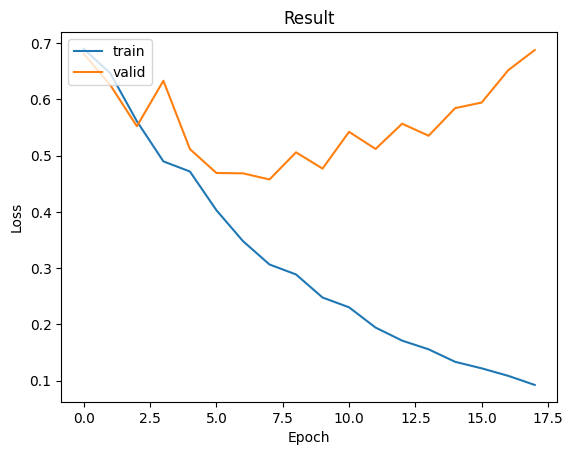

In [11]:
from trainer import Trainer
trainer = Trainer(
    epochs=100, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    model=model, 
    optimizer=[optimizer],
)
trainer.train(show_loss=True)

## 優化模型

Valid Epoch 0: 100%|██████████| 313/313 [00:03<00:00, 100.21it/s, loss=0.686]


Saving Model With Loss 0.69280
Train Loss: 0.69289| Valid Loss: 0.69280| Best Loss: 0.69280



Valid Epoch 1: 100%|██████████| 313/313 [00:03<00:00, 97.41it/s, loss=0.675] 


Saving Model With Loss 0.69246
Train Loss: 0.69227| Valid Loss: 0.69246| Best Loss: 0.69246



Valid Epoch 2: 100%|██████████| 313/313 [00:03<00:00, 95.80it/s, loss=0.683]


Train Loss: 0.69232| Valid Loss: 0.69259| Best Loss: 0.69246



Valid Epoch 3: 100%|██████████| 313/313 [00:03<00:00, 97.78it/s, loss=0.709] 


Saving Model With Loss 0.69006
Train Loss: 0.69161| Valid Loss: 0.69006| Best Loss: 0.69006



Valid Epoch 4: 100%|██████████| 313/313 [00:03<00:00, 96.61it/s, loss=0.692]


Train Loss: 0.67897| Valid Loss: 0.69091| Best Loss: 0.69006



Valid Epoch 5: 100%|██████████| 313/313 [00:03<00:00, 95.81it/s, loss=0.724]


Saving Model With Loss 0.68534
Train Loss: 0.68770| Valid Loss: 0.68534| Best Loss: 0.68534



Valid Epoch 6: 100%|██████████| 313/313 [00:03<00:00, 95.99it/s, loss=0.732]


Train Loss: 0.63542| Valid Loss: 0.69966| Best Loss: 0.68534



Valid Epoch 7: 100%|██████████| 313/313 [00:03<00:00, 93.74it/s, loss=0.482]


Saving Model With Loss 0.47822
Train Loss: 0.53530| Valid Loss: 0.47822| Best Loss: 0.47822



Valid Epoch 8: 100%|██████████| 313/313 [00:03<00:00, 94.89it/s, loss=0.589] 


Saving Model With Loss 0.41849
Train Loss: 0.43814| Valid Loss: 0.41849| Best Loss: 0.41849



Valid Epoch 9: 100%|██████████| 313/313 [00:03<00:00, 97.00it/s, loss=0.451] 


Saving Model With Loss 0.40949
Train Loss: 0.39165| Valid Loss: 0.40949| Best Loss: 0.40949



Valid Epoch 10: 100%|██████████| 313/313 [00:03<00:00, 97.04it/s, loss=0.715] 


Train Loss: 0.36426| Valid Loss: 0.42183| Best Loss: 0.40949



Valid Epoch 11: 100%|██████████| 313/313 [00:03<00:00, 96.01it/s, loss=0.475]


Train Loss: 0.33992| Valid Loss: 0.42158| Best Loss: 0.40949



Valid Epoch 12: 100%|██████████| 313/313 [00:03<00:00, 94.66it/s, loss=0.403] 


Saving Model With Loss 0.40052
Train Loss: 0.31926| Valid Loss: 0.40052| Best Loss: 0.40052



Valid Epoch 13: 100%|██████████| 313/313 [00:03<00:00, 92.40it/s, loss=0.502]


Train Loss: 0.30174| Valid Loss: 0.41780| Best Loss: 0.40052



Valid Epoch 14: 100%|██████████| 313/313 [00:03<00:00, 97.30it/s, loss=0.056] 


Train Loss: 0.28616| Valid Loss: 0.45832| Best Loss: 0.40052



Valid Epoch 15: 100%|██████████| 313/313 [00:03<00:00, 96.66it/s, loss=0.425] 


Saving Model With Loss 0.39940
Train Loss: 0.26996| Valid Loss: 0.39940| Best Loss: 0.39940



Valid Epoch 16: 100%|██████████| 313/313 [00:03<00:00, 97.16it/s, loss=0.200] 


Train Loss: 0.25967| Valid Loss: 0.41291| Best Loss: 0.39940



Valid Epoch 17: 100%|██████████| 313/313 [00:03<00:00, 94.72it/s, loss=0.208]


Train Loss: 0.24537| Valid Loss: 0.40910| Best Loss: 0.39940



Valid Epoch 18: 100%|██████████| 313/313 [00:03<00:00, 92.44it/s, loss=0.465]


Train Loss: 0.23590| Valid Loss: 0.41193| Best Loss: 0.39940



Valid Epoch 19: 100%|██████████| 313/313 [00:03<00:00, 88.03it/s, loss=0.451]


Train Loss: 0.22996| Valid Loss: 0.49709| Best Loss: 0.39940



Valid Epoch 20: 100%|██████████| 313/313 [00:03<00:00, 96.34it/s, loss=0.330]


Train Loss: 0.22003| Valid Loss: 0.41854| Best Loss: 0.39940



Valid Epoch 21: 100%|██████████| 313/313 [00:03<00:00, 96.50it/s, loss=0.834] 


Train Loss: 0.21970| Valid Loss: 0.47761| Best Loss: 0.39940



Valid Epoch 22: 100%|██████████| 313/313 [00:03<00:00, 96.50it/s, loss=0.267]


Train Loss: 0.21115| Valid Loss: 0.48142| Best Loss: 0.39940



Valid Epoch 23: 100%|██████████| 313/313 [00:03<00:00, 95.39it/s, loss=0.905] 


Train Loss: 0.20759| Valid Loss: 0.45514| Best Loss: 0.39940



Valid Epoch 24: 100%|██████████| 313/313 [00:03<00:00, 94.75it/s, loss=0.506]


Train Loss: 0.20667| Valid Loss: 0.45260| Best Loss: 0.39940



Valid Epoch 25: 100%|██████████| 313/313 [00:03<00:00, 97.62it/s, loss=0.541] 


------------------------------------
|Model can't improve, stop training|
------------------------------------


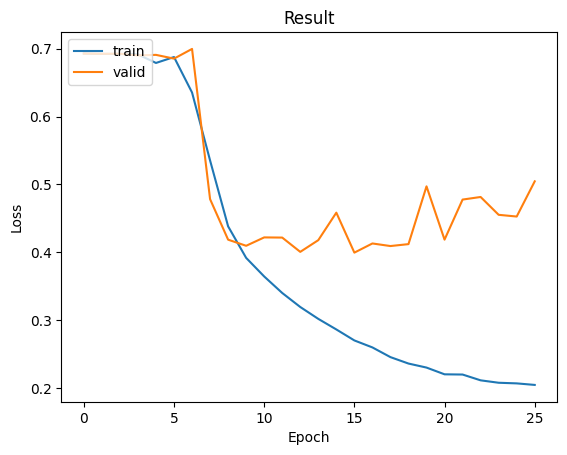

In [14]:
# 初始化模型與優化器
model = TimeSeriesModel(
    vocab_size=len(tokenizer), 
    embedding_dim=50, 
    hidden_size=32, 
    model_type='LSTM', 
    padding_idx=tokenizer.pad_token_id
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

# 開始訓練
trainer = Trainer(
    epochs=100, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    model=model, 
    optimizer=[optimizer],
)
trainer.train(show_loss=True)

## 用測試集驗證準確率

In [17]:
# 讀取最佳的模型
model.load_state_dict(torch.load('model.ckpt'))
# 切換成評估模式
model.eval()


total_correct = 0
total_samples = 0

with torch.no_grad():
    for input_data in valid_loader:
        input_datas = {k: v.to(device) for k, v in input_data.items()}
        _, logit = model(**input_datas)
        
        pred = (logit > 0.5).long()  # 將布林值轉換為整數（0或1）
        labels = input_datas['labels']
        
        total_correct += torch.sum(pred.view(-1) == labels).item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f'Validation Accuracy: {accuracy*100:.3f} %')

Validation Accuracy: 82.540 %
